# Introduction – Modélisation par Réseau Bayésien

Dans le cadre de ce projet, l’objectif est de construire un modèle probabiliste sous forme de **réseau bayésien**, permettant de modéliser et prédire un phénomène complexe basé sur plusieurs variables interdépendantes.  

Ce travail se base sur mes expérience personnelles.

Le sujet retenu porte sur la **prédiction de la réussite d’un déploiement de fonctionnalité en production**. Cette situation courante dans le monde du développement logiciel implique de nombreux facteurs techniques, organisationnels et humains. L'utilisation d’un réseau bayésien permet ici de modéliser ces influences multiples, et d'estimer la probabilité qu’un déploiement se passe sans incident en fonction de différents scénarios.

# Question 1 – Variables discrètes

Proposez 5 à 10 variables discrètes pertinentes pour ce modèle (et leur domaine de définition).
ASTUCE : Pour vous simplifier la vie dans la question suivante, n’utilisez que des variables prenant 2 ou 3 valeurs.

# Réponse 1

| **Nom des variables**      | **Description**                                                                            | **Valeurs**                                  | **Catégorie**               |
|----------------------------|--------------------------------------------------------------------------------------------|----------------------------------------------|-----------------------------|
| `Developer_Experience`     | Niveau du développeur                                                                      | `Beginner`, `Advanced`                       | Variable d'entrée           |
| `Code_Review`              | Le code a-t-il été relu par un pair                                                        | `No`, `Yes`                                  | Variable d'entrée           |
| `Technical_Documentation`  | Qualité de la documentation technique                                                      | `Poor`, `Good`                               | Variable d'entrée           |
| `Automated_Tests`          | Présence de tests automatisés                                                              | `No`, `Yes`                                  | Variable d'entrée           |
| `Unit_Tests_Result`        | Résultat des tests unitaires                                                               | `Failed`, `Passed`                           | Variable d'entrée           |
| `Preprod_Available`        | Disponibilité d’un environnement de préproduction                                          | `No`, `Yes`                                  | Variable d'entrée           |
| `Successful_Deployment`    | Résultat final du déploiement (succès ou échec)                                            | `No`, `Yes`                                  | Variable cible              |

# Question 2 – Graphe du réseau bayésien

Proposez le graphe d’un réseau bayésien modélisant ce problème, à partir des variables identifiées, en justifiant le choix de ce graphe.
ASTUCE : Pour éviter d’avoir une variable avec trop de parents, n’hésitez pas à rajouter des variables intermédiaires.

# Réponse 2

| **Nom des variables**      | **Description**                                                                            | **Valeurs**                                  | **Catégorie**               |
|----------------------------|--------------------------------------------------------------------------------------------|----------------------------------------------|-----------------------------|
| `Technical_Preparation`    | Qualité de la préparation technique (selon l’expérience, revue de code, documentation...)  | `Bad`, `Good`                                | Variable intermédiaire      |
| `Test_Quality`             | Niveau de confiance dans la stratégie de test                                              | `Bad`, `Good`                                | Variable intermédiaire      |
| `Undetected_Bugs`          | Présence de problèmes non détectés avant la production                                     | `No`, `Yes`                                  | Variable intermédiaire      |

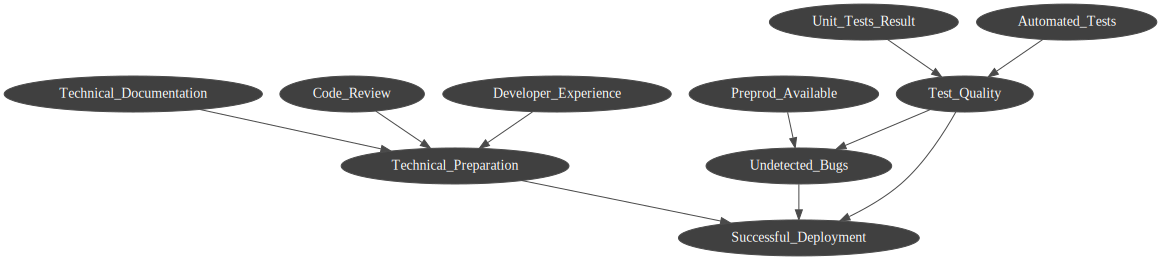

In [8]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb

# --- Définition du Réseau Bayésien (BN) ---
bn = gum.BayesNet('Production_Deployment')

bn.add(gum.LabelizedVariable("Developer_Experience", "", ["Beginner", "Advanced"]))
bn.add(gum.LabelizedVariable("Code_Review", "", ["No", "Yes"]))
bn.add(gum.LabelizedVariable("Technical_Documentation", "", ["Poor", "Good"]))
bn.add(gum.LabelizedVariable("Automated_Tests", "", ["No", "Yes"]))
bn.add(gum.LabelizedVariable("Unit_Tests_Result", "", ["Failed", "Passed"]))
bn.add(gum.LabelizedVariable("Preprod_Available", "", ["No", "Yes"]))
bn.add(gum.LabelizedVariable("Technical_Preparation", "", ["Bad", "Good"]))
bn.add(gum.LabelizedVariable("Test_Quality", "", ["Bad", "Good"]))
bn.add(gum.LabelizedVariable("Undetected_Bugs", "", ["No", "Yes"]))
bn.add(gum.LabelizedVariable("Successful_Deployment", "", ["No", "Yes"]))

bn.addArc("Developer_Experience", "Technical_Preparation")
bn.addArc("Code_Review", "Technical_Preparation")
bn.addArc("Technical_Documentation", "Technical_Preparation")
bn.addArc("Automated_Tests", "Test_Quality")
bn.addArc("Unit_Tests_Result", "Test_Quality")
bn.addArc("Test_Quality", "Undetected_Bugs")
bn.addArc("Preprod_Available", "Undetected_Bugs")
bn.addArc("Technical_Preparation", "Successful_Deployment")
bn.addArc("Test_Quality", "Successful_Deployment")
bn.addArc("Undetected_Bugs", "Successful_Deployment")

# --- Affichage final ---
gnb.showBN(bn, size="19")

# Question 3 – Probabilités conditionnelles

Proposez des distribution de probabilité conditionnelles pour vos variables, afin de définir entièrement le réseau bayésien, en justifiant le choix des valeurs numériques de ces distributions. Essayez d’avoir au moins une application du NoisyOR dans votre modèle.

# Réponse 3

## 1. Distributions de probabilité a priori

| **Variable**                | **Valeurs**                              | **Distribution**                               |
|-----------------------------|------------------------------------------|------------------------------------------------|
| `Developer_Experience`      | `Beginner`, `Advanced`                   | `[0.3, 0.7]`                                   |
| `Code_Review`               | `No`, `Yes`                              | `[0.75, 0.25]`                                 |
| `Technical_Documentation`   | `Poor`, `Good`                           | `[0.8, 0.2]`                                   |
| `Automated_Tests`           | `No`, `Yes`                              | `[0.9, 0.1]`                                   |
| `Unit_Tests_Result`         | `Failed`, `Passed`                       | `[0.3, 0.7]`                                   |
| `Preprod_Available`         | `No`, `Yes`                              | `[0.15, 0.85]`                                 |

Les distributions de probabilité à priori sont basées sur une intuition réaliste et sur mes expériences.

## 2. Distributions de probabilité conditionnelles

Utilisation de la formule du Leaky NoisyOR pour les variables intermédiaires et la variable cible.

# Question 4 – Implémentation

Implémentez votre modèle avec pyAgrum, et montrez la "qualité" de votre modèle en observant la probabilité de réussite dans différents scénarios possibles, du pire scénario possible, au meilleur, en passant par des situations intermédiaires.

# Réponse 4

In [9]:
import itertools

# --- Remplissage des Probabilités A Priori ---
try:
    bn.cpt("Developer_Experience").fillWith([0.3, 0.7])
    bn.cpt("Code_Review").fillWith([0.75, 0.25])
    bn.cpt("Technical_Documentation").fillWith([0.8, 0.2])
    bn.cpt("Automated_Tests").fillWith([0.9, 0.1])
    bn.cpt("Unit_Tests_Result").fillWith([0.3, 0.7])
    bn.cpt("Preprod_Available").fillWith([0.15, 0.85])
    print("Probabilités a priori définies.")
except Exception as e:
    print(f"Erreur lors de la définition des probabilités a priori : {e}")


# --- Fonction pour calculer une CPT avec Leaky Noisy-OR ---
def calculate_noisy_or(bn: gum.BayesNet, child_var: str, parent_vars: list[str], causal_params: dict[tuple[str, int]], leak_prob: float) -> None:
    try:
        child_labels = bn.variable(child_var).labels()
        if len(child_labels) != 2:
            raise ValueError(f"La logique Leaky Noisy-OR implémentée ici ne supporte que les enfants binaires. '{child_var}' a {len(child_labels)} états.")

        parent_states_list = [bn.variable(parent).labels() for parent in parent_vars]
        parent_state_combinations = list(itertools.product(*parent_states_list))

        cpt_list = []
        for _, parent_combination_tuple in enumerate(parent_state_combinations):
            parent_combination_dict = {parent_vars[j]: state for j, state in enumerate(parent_combination_tuple)}

            prob_no_effect = (1.0 - leak_prob)

            for parent_name, current_parent_state in parent_combination_dict.items():
                causal_state, p_i = causal_params[parent_name]

                if current_parent_state == causal_state:
                    prob_no_effect *= (1.0 - p_i)

            prob_effect = 1.0 - prob_no_effect

            cpt_list.extend([prob_no_effect, prob_effect])

        bn.cpt(child_var).fillWith(cpt_list)
        print(f"CPT remplie avec Leaky Noisy-OR pour '{child_var}' ({len(parent_state_combinations)} combinaisons).")
    except Exception as e:
        print(f"Erreur lors du calcul/remplissage de la CPT Leaky Noisy-OR manuelle pour '{child_var}': {e}")

# --- Remplissage des Probabilités Conditionnelles (Leaky Noisy-Or) ---
child = "Technical_Preparation"
parents = ["Developer_Experience", "Code_Review", "Technical_Documentation"]
leak = 0.1
params = {"Developer_Experience": ("Advanced", 0.6), "Code_Review": ("Yes", 0.3), "Technical_Documentation": ("Good", 0.2)}
calculate_noisy_or(bn, child, parents, params, leak)

child = "Test_Quality"
parents = ["Automated_Tests", "Unit_Tests_Result"]
leak = 0.05
params = {"Automated_Tests": ("Yes", 0.4), "Unit_Tests_Result": ("Passed", 0.7)}
calculate_noisy_or(bn, child, parents, params, leak)

child = "Undetected_Bugs"
parents = ["Test_Quality", "Preprod_Available"]
leak = 0.05    
params = {"Test_Quality": ("Bad", 0.4), "Preprod_Available": ("No", 0.7)}
calculate_noisy_or(bn, child, parents, params, leak)

child = "Successful_Deployment"
parents = ["Technical_Preparation", "Test_Quality", "Undetected_Bugs"]
leak = 0.02
params = {"Technical_Preparation": ("Bad", 0.7), "Test_Quality": ("Good", 0.4), "Undetected_Bugs": ("Yes", 0.6)}
calculate_noisy_or(bn, child, parents, params, leak)

Probabilités a priori définies.
CPT remplie avec Leaky Noisy-OR pour 'Technical_Preparation' (8 combinaisons).
CPT remplie avec Leaky Noisy-OR pour 'Test_Quality' (4 combinaisons).
CPT remplie avec Leaky Noisy-OR pour 'Undetected_Bugs' (4 combinaisons).
CPT remplie avec Leaky Noisy-OR pour 'Successful_Deployment' (8 combinaisons).


In [10]:
bn.cpt("Technical_Preparation")

(pyagrum.Tensor@0x1c249050) 
                    ||  Technical_Prepara|
Develo|Code_R|Techni||Bad      |Good     |
------|------|------||---------|---------|
Beginn|No    |Poor  || 0.9000  | 0.1000  |
Advanc|No    |Poor  || 0.7200  | 0.2800  |
Beginn|Yes   |Poor  || 0.6300  | 0.3700  |
Advanc|Yes   |Poor  || 0.5040  | 0.4960  |
Beginn|No    |Good  || 0.3600  | 0.6400  |
Advanc|No    |Good  || 0.2880  | 0.7120  |
Beginn|Yes   |Good  || 0.2520  | 0.7480  |
Advanc|Yes   |Good  || 0.2016  | 0.7984  |

In [11]:
bn.cpt("Test_Quality")

(pyagrum.Tensor@0x1bb51fc0) 
             ||  Test_Quality     |
Automa|Unit_T||Bad      |Good     |
------|------||---------|---------|
No    |Failed|| 0.9500  | 0.0500  |
Yes   |Failed|| 0.2850  | 0.7150  |
No    |Passed|| 0.5700  | 0.4300  |
Yes   |Passed|| 0.1710  | 0.8290  |

In [12]:
bn.cpt("Undetected_Bugs")

(pyagrum.Tensor@0x1bf8dca0) 
             ||  Undetected_Bugs  |
Test_Q|Prepro||No       |Yes      |
------|------||---------|---------|
Bad   |No    || 0.1710  | 0.8290  |
Good  |No    || 0.5700  | 0.4300  |
Bad   |Yes   || 0.2850  | 0.7150  |
Good  |Yes   || 0.9500  | 0.0500  |

In [13]:
bn.cpt("Successful_Deployment")

(pyagrum.Tensor@0x1b561c90) 
                    ||  Successful_Deploy|
Techni|Test_Q|Undete||No       |Yes      |
------|------|------||---------|---------|
Bad   |Bad   |No    || 0.2940  | 0.7060  |
Good  |Bad   |No    || 0.1176  | 0.8824  |
Bad   |Good  |No    || 0.1764  | 0.8236  |
Good  |Good  |No    || 0.0706  | 0.9294  |
Bad   |Bad   |Yes   || 0.9800  | 0.0200  |
Good  |Bad   |Yes   || 0.3920  | 0.6080  |
Bad   |Good  |Yes   || 0.5880  | 0.4120  |
Good  |Good  |Yes   || 0.2352  | 0.7648  |

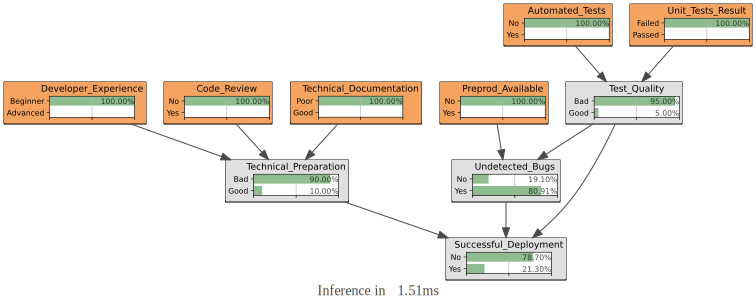

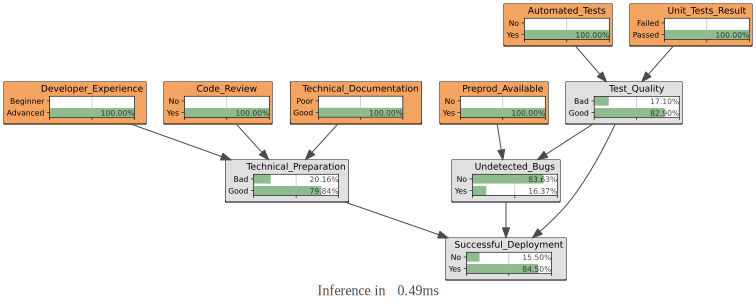

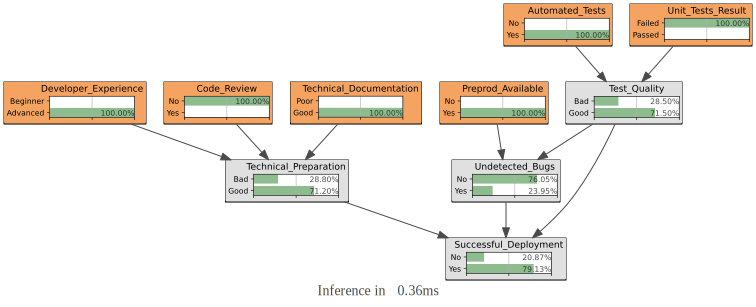

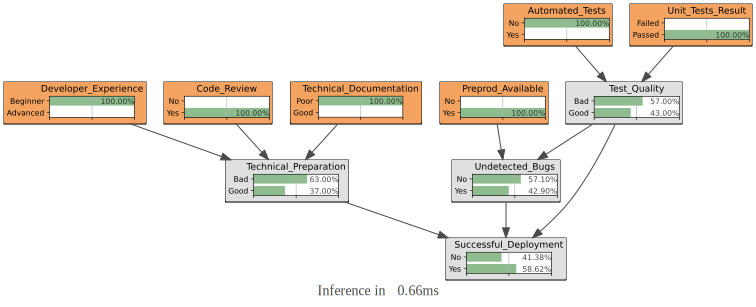

=== Tableau des résultats ===
WorstCase : 0.21 % de chances de succès
BestCase : 0.85 % de chances de succès
Intermediate1 : 0.79 % de chances de succès
Intermediate2 : 0.59 % de chances de succès


In [14]:
ie = gum.LazyPropagation(bn)

# --- Scénarios à évaluer ---
scenarios = {
    "WorstCase": {
        "Developer_Experience": "Beginner",
        "Code_Review": "No",
        "Technical_Documentation": "Poor",
        "Automated_Tests": "No",
        "Unit_Tests_Result": "Failed",
        "Preprod_Available": "No"
    },
    "BestCase": {
        "Developer_Experience": "Advanced",
        "Code_Review": "Yes",
        "Technical_Documentation": "Good",
        "Automated_Tests": "Yes",
        "Unit_Tests_Result": "Passed",
        "Preprod_Available": "Yes"
    },
    "Intermediate1": {
        "Developer_Experience": "Advanced",
        "Code_Review": "No",
        "Technical_Documentation": "Good",
        "Automated_Tests": "Yes",
        "Unit_Tests_Result": "Failed",
        "Preprod_Available": "Yes"
    },
    "Intermediate2": {
        "Developer_Experience": "Beginner",
        "Code_Review": "Yes",
        "Technical_Documentation": "Poor",
        "Automated_Tests": "No",
        "Unit_Tests_Result": "Passed",
        "Preprod_Available": "Yes"
    },
}

results = []

for scenario_name, scenario_values in scenarios.items():
    ie.setEvidence(scenario_values)
    ie.makeInference()

    post_sd = ie.posterior("Successful_Deployment")
    idx_yes = bn.variable("Successful_Deployment").index("Yes")
    p_success = post_sd[idx_yes]
    scenario_evs = {var: bn.variable(var).index(value) for var, value in scenario_values.items()}
    gnb.showInference(bn, evs=scenario_evs, size="16")
    results.append((scenario_name, p_success))


print("=== Tableau des résultats ===")
for scenario_name, p_success in results:
    print(f"{scenario_name} : {p_success:.2f} % de chances de succès")
